In [1]:
# 在一个新的Colab Notebook中开始

import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# 在 PyTorch_5.ipynb 中修改

from torchvision import transforms # 确保导入 transforms

# 定义一个包含标准化的、更健壮的预处理流程
# FashionMNIST 的均值和标准差都是 0.5
transform_with_norm = transforms.Compose([
    ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,)) # <--- 添加了这一行！
])

# 1. 加载 Fashion-MNIST 数据集 (使用新的transform)
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform_with_norm # <--- 应用新的transform
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform_with_norm # <--- 应用新的transform
)

print("数据已使用新的、包含标准化的流程重新加载！")


# 接下来，请你独立完成 DataLoader、模型构建、训练和评估...
# ...


100%|██████████| 26.4M/26.4M [00:03<00:00, 8.21MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 119kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.58MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.1MB/s]

数据已使用新的、包含标准化的流程重新加载！


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36825 (\N{CJK UNIFIED IDEOGRAPH-8FD9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26159 (\N{CJK UNIFIED IDEOGRAPH-662F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)



第一张图片的形状: torch.Size([1, 28, 28])
第一张图片的答案 (标签): 9


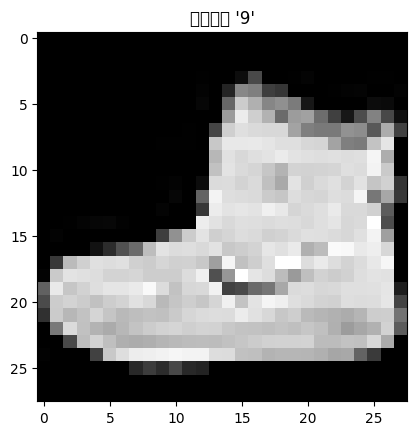

In [2]:
import matplotlib.pyplot as plt

# --- 让我们随便看一张图片和它的答案 ---
image, label = train_data[0]
print(f"\n第一张图片的形状: {image.shape}")
print(f"第一张图片的答案 (标签): {label}")

plt.imshow(image.squeeze(), cmap="gray") # .squeeze()是把 [1, 28, 28] 这种多余的维度去掉
plt.title(f"这是一个 '{label}'")
plt.show()

In [3]:
from torch.utils.data import DataLoader


BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=BATCH_SIZE, shuffle=True)


In [4]:
class FashionMNIST_Model( nn.Module ):
  def __init__(self):
    super().__init__()

    self.conv_block_1 = nn.Sequential(

      nn.Conv2d( in_channels=1, out_channels=10, kernel_size=3, stride=1,padding=1 ),
      # PyTorch语法详解：`nn.Conv2d`nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
      # in_channels (输入通道数): 输入图片的“厚度”。对于灰度图，是1。对于彩色图(RGB)，是3。
      # out_channels (输出通道数): 你想要使用多少个不同的卷积核（“手电筒”）。这个数字决定了输出的特征图的“厚度”。
      # kernel_size (卷积核大小): “手电筒光斑”的大小。可以是3 (代表3x3) 或 (3, 5)。
      # stride (步长): “手电筒”每次移动的格子数。默认为1。
      # padding (填充): 在图片的边缘填充一圈0。这可以防止卷积操作后图片尺寸变得太小，并更好地处理边缘信息。

      nn.ReLU(),

      nn.Conv2d( 10,10, kernel_size=3, stride=1,padding=1 ),

      nn.ReLU(),

      nn.MaxPool2d( kernel_size=2 )
      # 池化层 (nn.MaxPool2d)：高效的“摘要总结器”
      # 卷积层产生了大量的特征图，信息量仍然很大。池化层的作用就是对这些特征图进行“降维”或“总结”。
      # 核心思想：对特征图的某个小区域，只保留最重要的信息。
      # 工作原理 (最大池化 Max Pooling)：
      # 在特征图上选定一个窗口（比如2x2）。
      # 在这个2x2的区域内，只保留最大的那个值。
      # 窗口向右、向下移动，重复这个过程。
      # 结果：一张28x28的特征图，经过2x2的最大池化后，会变成一张14x14的新特征图。
      # 为什么这么做？
      # 减少计算量：显著减小了特征图的尺寸，后续层的参数和计算量都会大幅下降。
      # 增强平移不变性：我们只关心某个区域内有没有出现某个特征，而不关心它的精确位置。如果一个特征在2x2的窗口内稍微移动了一下，只要它仍然是最大值，池化后的结果就不会变。这使得模型对物体微小的位移不那么敏感，更加鲁棒。


    )



    self.classifier = nn.Sequential(

      nn.Flatten(),

      nn.Linear( in_features=10*14*14, out_features=10 )


    )

  def forward( self, x):
    x = self.conv_block_1(x)
    x = self.classifier(x)
    return x

In [5]:
# 实例化一个学生，并把它送到GPU上（如果Colab有的话）
device = "cuda" if torch.cuda.is_available() else "cpu"
model = FashionMNIST_Model().to(device)

print("--- 这是我们CNN学生的大脑结构 ---")
print(model)

--- 这是我们CNN学生的大脑结构 ---
FashionMNIST_Model(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1960, out_features=10, bias=True)
  )
)


In [6]:
# --- 准备教学工具 ---

# 1. 评分标准：最适合多分类问题的老师
loss_fn = nn.CrossEntropyLoss()

# 2. 反思方法：还是用强大的Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("教学工具准备好了！")

教学工具准备好了！


In [7]:
from tqdm.auto import tqdm # 这是一个能显示漂亮进度条的工具

# --- 开始上课 ---
epochs = 3 # 对于这个任务，学3遍效果就已经很好了
print("--- 教学开始 ---")

for epoch in tqdm(range(epochs)):
    # --- 训练 ---
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
        # 把数据也送到GPU
        X, y = X.to(device), y.to(device)

        # 1. 学生做题
        y_pred = model(X)

        # 2. 老师评分
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 计算准确率
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

        # 3. 学生反思与调整
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 计算平均损失和准确率
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    print(f"第 {epoch+1} 遍学习成果 -> 训练差距(Loss): {train_loss:.4f} | 训练准确率: {train_acc*100:.2f}%")

print("--- 教学结束 ---")

--- 教学开始 ---


  0%|          | 0/3 [00:00<?, ?it/s]

第 1 遍学习成果 -> 训练差距(Loss): 0.4243 | 训练准确率: 85.07%
第 2 遍学习成果 -> 训练差距(Loss): 0.2905 | 训练准确率: 89.78%
第 3 遍学习成果 -> 训练差距(Loss): 0.2539 | 训练准确率: 91.01%
--- 教学结束 ---



--- 毕业考试成绩 ---
考试差距(Loss): 0.2692 | 考试准确率: 90.28%


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31572 (\N{CJK UNIFIED IDEOGRAPH-7B54}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26696 (\N{CJK UNIFIED IDEOGRAPH-6848}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29468 (\N{CJK UNIFIED IDEOGRAPH-731C}) missing from font(s) DejaVu Sans.
  fig.canvas

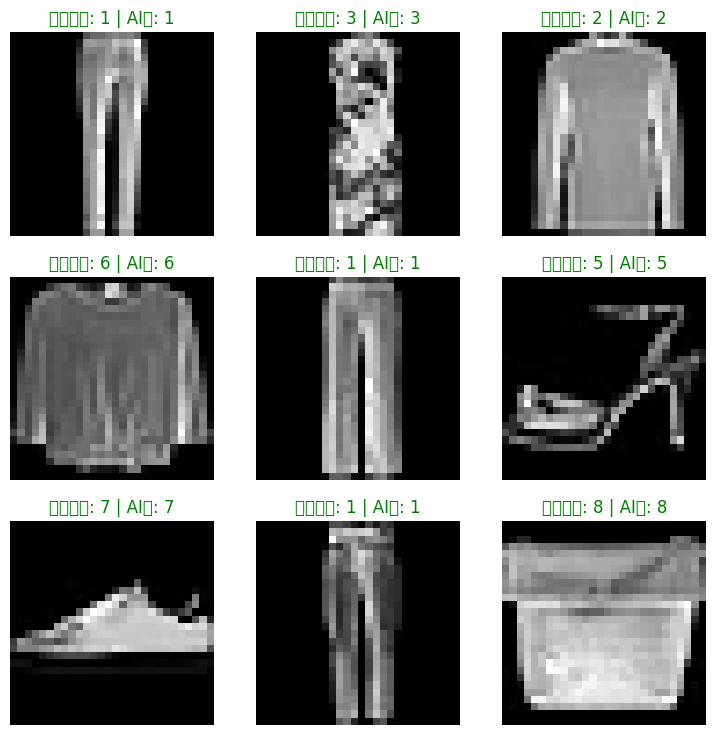

In [8]:
# --- 毕业统考 ---
model.eval()
test_loss, test_acc = 0, 0
with torch.no_grad(): # 进入考试模式，不反思
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        test_pred = model(X)
        test_loss += loss_fn(test_pred, y).item()
        test_acc += (torch.argmax(test_pred, dim=1) == y).sum().item() / len(test_pred)

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

print(f"\n--- 毕业考试成绩 ---\n考试差距(Loss): {test_loss:.4f} | 考试准确率: {test_acc*100:.2f}%")

# --- 让我们随机抽几张卷子，看看它答得怎么样 ---
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

pred_classes = []
model.eval()
with torch.no_grad():
    for sample in test_samples:
        pred_logit = model(sample.unsqueeze(0).to(device))
        pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
        pred_classes.append(torch.argmax(pred_prob).cpu().item())

plt.figure(figsize=(9, 9))
for i, sample in enumerate(test_samples):
    plt.subplot(3, 3, i+1)
    plt.imshow(sample.squeeze(), cmap="gray")
    title_text = f"真实答案: {test_labels[i]} | AI猜: {pred_classes[i]}"
    # 如果猜对了是绿色，猜错了是红色
    if test_labels[i] == pred_classes[i]:
        plt.title(title_text, c="g")
    else:
        plt.title(title_text, c="r")
    plt.axis(False)
plt.show()

In [9]:
# 1. 定义类别名称 (必须和Fashion-MNIST的官方顺序一致)
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

# 2. 定义模型的保存路径
MODEL_SAVE_PATH = "fashion_mnist_cnn_model.pth"

# 3. 保存模型的状态字典 (state_dict)
print(f"正在将模型保存到: {MODEL_SAVE_PATH}")
# 假设你训练好的模型实例叫 model
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)
print("模型保存成功！")

# 4. 从Colab下载模型文件到你的本地电脑
from google.colab import files
files.download(MODEL_SAVE_PATH)


正在将模型保存到: fashion_mnist_cnn_model.pth
模型保存成功！


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>